In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import copy

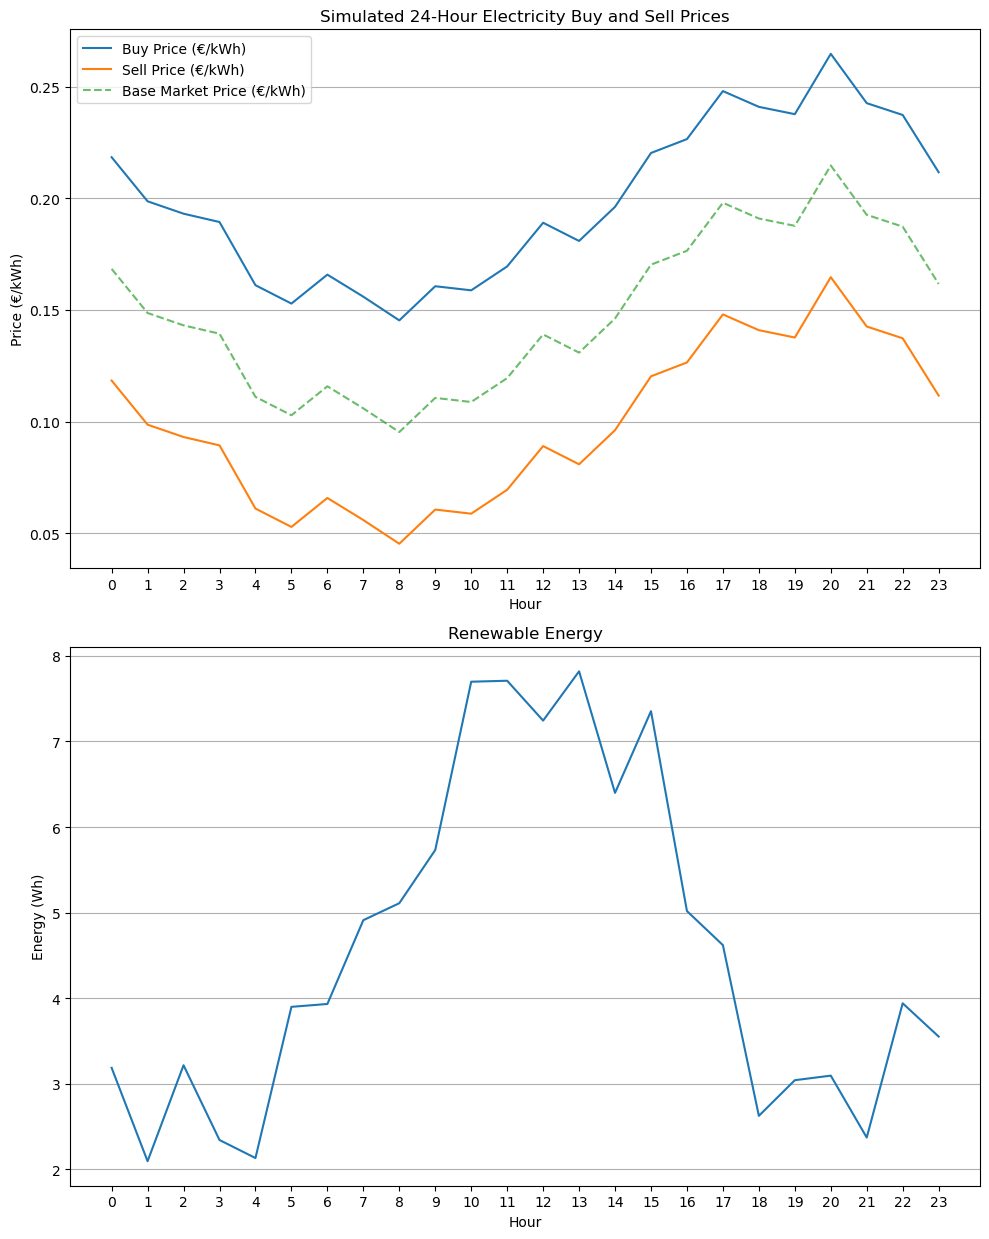

In [25]:
# Set seed for reproducibility
np.random.seed(42)

# === 1. Time Horizon ===
H = 24
hours = np.arange(H)
base_price = 0.15
amplitude = 0.10
noise = np.random.normal(0, 0.01, size=H)

# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)

# Add asymmetric buy/sell prices
margin = 0.05
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices


# === 3. Generate Renewable Energy ===
pv_gen = np.maximum(0, 5 * np.sin((hours - 6) * np.pi / 12))  # PV peaks at noon
wt_gen = 2 + np.random.rand(H) * 2  # Wind is random but consistent
q = (pv_gen + wt_gen)


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

# First subplot: Buy and Sell Prices
axs[0].plot(hours, c, label='Buy Price (€/kWh)')
axs[0].plot(hours, p, label='Sell Price (€/kWh)')
axs[0].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[0].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Price (€/kWh)")
axs[0].grid(axis='y')
axs[0].set_xticks(range(0, 24))
axs[0].legend()

# Second subplot: Renewable energy
axs[1].plot(np.arange(H), q)
axs[1].set_title("Renewable Energy")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Energy (Wh)")
axs[1].grid(axis='y')
axs[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.savefig("Decentralised environmental parameters", dpi=300)
plt.show()

In [97]:
# Constants
N = 5   # Number of agents
rho = 1.8 #1.8
gamma = 0.09

epsilon = 0.1
c1 = 5
eta = 0.9

# Random seeds for reproducibility
np.random.seed(42)

L_target = np.random.uniform(70, 90, size=N)
L_init = np.random.uniform(20, 60, size=N)

L_min = np.ones((N, H)) * 20
L_max = np.ones((N, H)) * 100

d_min = np.zeros((N, H))
d_max = np.ones((N, H)) * 10

f_min = np.zeros((N, H))
f_max = np.ones((N, H)) * 10

l_min = np.zeros((N, H))
l_max = np.ones((N, H)) * 10

m_min = np.zeros((N, H))
m_max = np.ones((N, H)) * 10

# Initial values
x = np.array([np.zeros(5*H) for _ in range(N)])  # d, f, l, m, L[1:]
lambdas = np.zeros(H)

x_prev = copy.deepcopy(x)
iteration = 0

# Collect data for plotting
d_history = np.array([np.zeros(H) for n in range(N)])
f_history = np.array([np.zeros(H) for n in range(N)])
l_history = np.array([np.zeros(H) for n in range(N)])
m_history = np.array([np.zeros(H) for n in range(N)])
L_history = np.array([np.zeros(H) for n in range(N)])

cost_terms = []
penalty_terms = []

H_n_T_x = np.zeros((N,H))
H_n_T_xi = np.zeros((N,H))
# ADMM loop
while True:
    iteration += 1
    
    final_cost = 0
    for n in range(N):
        # Variables
        constraints = []
        xi = cp.Variable(5*H)
        d = xi[:H]
        f = xi[H:2*H]
        l = xi[2*H:3*H]
        m = xi[3*H:4*H]
        L = xi[4*H:]

        # Objective components
        net_cost = c1*cp.sum(c @ d / q - p @ f / q)
    
        charge_penalty = (L[-1] - L_target[n])**2
    
        h_n_T_x = -d + f + l - m
        admm_penalty = (rho / 2) *  cp.sum_squares(h_n_T_x  + cp.sum(H_n_T_x,axis=0) - H_n_T_x[n] - q - 1/rho * lambdas)

        admm_update = 4.5 *cp.sum_squares(xi - x_prev[n])

        objective = cp.Minimize(net_cost + charge_penalty + admm_penalty +  admm_update)

        # Constraints
        constraints += [
            L >= L_min[n],
            L <= L_max[n],
            d >= d_min[n],
            d <= d_max[n],
            f >= f_min[n],
            f <= f_max[n],
            l >= l_min[n],
            l <= l_max[n],
            m >= m_min[n],
            m <= m_max[n]
        ]
        
        constraints += [
            L[0] == L_init[n] + l[0] - m[0]
        ]
        for h in range(1, H):
            constraints += [
                L[h] == L[h-1] + l[h] - m[h],
                cp.abs(l[h-1] - l[h]) <= 1,
                cp.abs(m[h-1] - m[h]) <= 1,
                cp.abs(d[h-1] - d[h]) <= 1,
                cp.abs(f[h-1] - f[h]) <= 1,
            ]

        # Solve
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, warm_start=True)
        """
        print(f"######### Parameters for Agent: {n} ##########")
        print(f"Net cost: {net_cost.value}")
        print(f"Charge penalty: {charge_penalty.value}")
        print(f"Lambda penalty: {admm_penalty.value}")
        print(f"Update penalty: {admm_update.value}")
        print(f"Objective value: {objective.value}")
        print(f"############################################")
        print(f" ")
        """
        # Save values
        x[n] = copy.deepcopy(xi.value)
        H_n_T_xi[n] = copy.deepcopy(h_n_T_x.value)

        # Collect data for plotting
        d_history[n] = copy.deepcopy(d.value)
        f_history[n] = copy.deepcopy(f.value)
        l_history[n] = copy.deepcopy(l.value)
        m_history[n] = copy.deepcopy(m.value)
        L_history[n] = copy.deepcopy(L.value)

        final_cost += net_cost.value + charge_penalty.value
    
    H_n_T_x = copy.deepcopy(H_n_T_xi)
    
    lambdas -= gamma * rho * (np.sum(H_n_T_x, axis=0) - q)
    #gamma *=0.9
    print("--------------------------------------------")
    print(f"ITERATION: {iteration}, difference: {np.linalg.norm(x-x_prev)}, lambda {np.mean(np.sum(H_n_T_x, axis=0) - q)}")
    print("--------------------------------------------")
    print(f" ")
    
    if np.linalg.norm(x-x_prev) <= epsilon:
        break
    
    x_prev = copy.deepcopy(x)
    
print(final_cost)

--------------------------------------------
ITERATION: 1, difference: 236.47617653731987, lambda -5.767708594333684
--------------------------------------------
 
--------------------------------------------
ITERATION: 2, difference: 26.40969669917559, lambda -1.3403463919212364
--------------------------------------------
 
--------------------------------------------
ITERATION: 3, difference: 17.70579467612396, lambda -1.091157723985171
--------------------------------------------
 
--------------------------------------------
ITERATION: 4, difference: 15.552125036976248, lambda -1.138466978687437
--------------------------------------------
 
--------------------------------------------
ITERATION: 5, difference: 13.976527714894829, lambda -1.1060546172006496
--------------------------------------------
 
--------------------------------------------
ITERATION: 6, difference: 12.733994693253537, lambda -1.0397801739127857
--------------------------------------------
 
---------------

KeyboardInterrupt: 

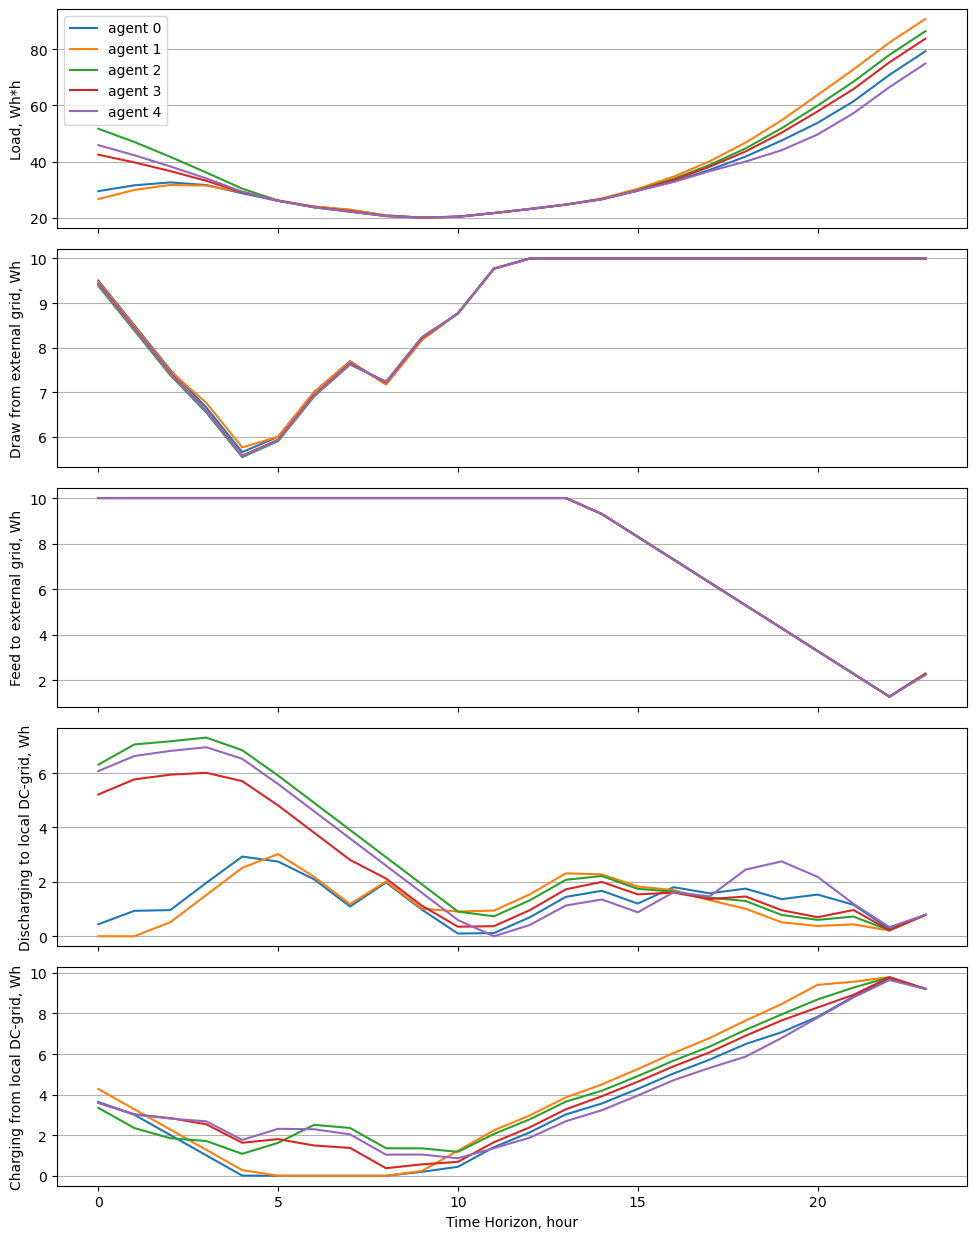

In [99]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)

for n in range(N):
    #axes[0].plot(np.full(H,L_target[n]))
    axes[0].plot(L_history[n], label =f'agent {n}')
    axes[0].grid(axis='y')
    axes[0].legend()
    axes[0].set_ylabel("Load, Wh*h")

for n in range(N):
    axes[1].plot(d_history[n])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")

for n in range(N):
    axes[2].plot(f_history[n])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
    
for n in range(N):
    axes[3].plot(m_history[n])
    axes[3].grid(axis='y')
    axes[3].set_ylabel("Discharging to local DC-grid, Wh")
    
for n in range(N):
    axes[4].plot(l_history[n])
    axes[4].grid(axis='y')
    axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Decentralised framework", dpi=300)
plt.show()

0.0006299853818757714
2.8956715876661165e-05
2.8956715876661158e-05


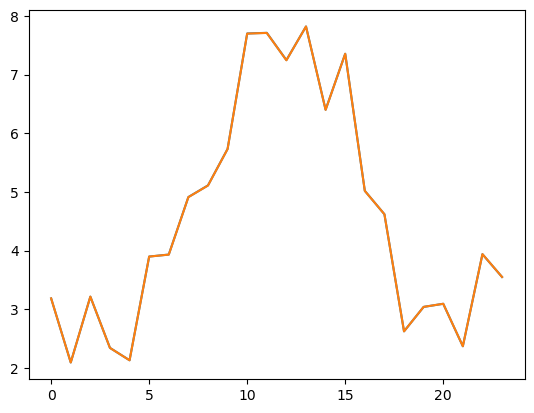

In [93]:
plt.plot(-np.sum(d_history,axis=0)+np.sum(f_history,axis=0)+np.sum(l_history,axis=0)-np.sum(m_history,axis=0))
plt.plot(q)
print(np.mean(np.sum(H_n_T_x,axis=0)-q))
print((np.sum(H_n_T_x,axis=0)-q).T @ (np.sum(H_n_T_x,axis=0)-q))
print(cp.sum_squares(np.sum(H_n_T_x,axis=0)-q).value)

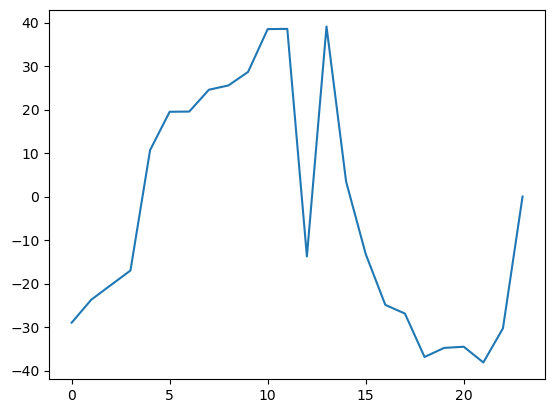

In [92]:
plt.plot(np.sum(l_history,axis=0)-np.sum(m_history,axis=0))

In [129]:
lambdas

array([-1.73097262e+04,  8.69771757e-05, -1.90743717e+04, -2.28737477e+03,
        1.37819320e-04, -5.68497842e+03, -6.99271822e+03, -9.60631693e+03,
       -1.01519685e+04, -1.99999999e+04, -1.99999999e+04, -1.99999999e+04,
       -1.99999999e+04, -1.99999999e+04, -1.99999999e+04, -1.99999999e+04,
       -9.77700975e+03,  6.50514598e-05,  1.11609422e-04,  1.08579377e-04,
        9.04815015e-05,  1.14231116e-04,  9.39560478e-05,  1.21416966e-04])

In [90]:
print(final_cost)

1703.3309036515152


In [81]:
for n in range(N):
    print(f"Error between target and real load of {1+n} agent is {100 * (L_target[n] - L_history[n][-1])/L_target[n]:.2f}%")

Error between target and real load of 1 agent is 5.52%
Error between target and real load of 2 agent is 4.81%
Error between target and real load of 3 agent is 5.06%
Error between target and real load of 4 agent is 5.23%
Error between target and real load of 5 agent is 5.86%


In [101]:
c1 * np.sum(c @ np.sum(d_history,axis=0)/q - p @ np.sum(f_history,axis=0)/q) + (L_target - L_history[:,-1]).T@(L_target - L_history[:,-1])

4147.36811124582

In [46]:
np.sum((c @ np.sum(f_history,axis=0)/q - p @ np.sum(d_history,axis=0))/q)

-122.94848145433234